In [1]:
import glob
import os
import pickle
import time
import matplotlib.pyplot as plt
import cv2
import numpy as np
import torch
import torch.nn.functional as F
from scripts.gifMaker import make_gif_from_array
from src.common import as_intrinsics_matrix
from torch.utils.data import Dataset
import threading
from tqdm import tqdm
from src.utils.datasets import get_dataset
import time

import torch.multiprocessing as mp
from src.utils import backproject, create_instance_seg, id_generation, vis
import argparse
from src.NICE_SLAM import NICE_SLAM
from src import config
import seaborn as sns
from src.Segmenter import Segmenter

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
parser = argparse.ArgumentParser(
description="Arguments for running the NICE-SLAM/iMAP*."
)
parser.add_argument("config", type=str, help="Path to config file.")
parser.add_argument(
    "--input_folder",
    type=str,
    help="input folder, this have higher priority, can overwrite the one in config file",
)
parser.add_argument(
    "--output",
    type=str,
    help="output folder, this have higher priority, can overwrite the one in config file",
)
nice_parser = parser.add_mutually_exclusive_group(required=False)
nice_parser.add_argument("--nice", dest="nice", action="store_true")
nice_parser.add_argument("--imap", dest="nice", action="store_false")
parser.set_defaults(nice=True)
args = parser.parse_args(args=['/home/rozenberszki/project/wsnsl/configs/ScanNet/scene0300_01.yaml'])
#args = parser.parse_args(args=['/home/rozenberszki/project/wsnsl/configs/Own/room0.yaml'])

cfg = config.load_config(  # J:changed it to use our config file including semantics
        args.config, "configs/nice_slam_sem.yaml" if args.nice else "configs/imap.yaml"
    )
slam = NICE_SLAM(cfg, args)
frame_reader = get_dataset(cfg, args, cfg["scale"], slam = slam)
frame_reader.__post_init__(slam)
zero_pos = frame_reader.poses[0]
zero_pos

INFO: The output folder is output_imap/scannet/scene0300_01
INFO: The GT, generated and residual depth/color images can be found under output_imap/scannet/scene0300_01/mapping_vis/
INFO: The mesh can be found under output_imap/scannet/scene0300_01/mesh/
INFO: The checkpoint can be found under output_imap/scannet/scene0300_01/ckpt/


tensor([[ 0.9984, -0.0545,  0.0146,  6.0893],
        [ 0.0275,  0.2440, -0.9694,  4.8627],
        [ 0.0493,  0.9682,  0.2451,  1.4598],
        [ 0.0000,  0.0000,  0.0000,  1.0000]])

In [5]:
import glob
import os
import pickle
import time
import matplotlib.pyplot as plt
import cv2
import numpy as np
import torch
import torch.nn.functional as F
from scripts.gifMaker import make_gif_from_array
from src.common import as_intrinsics_matrix
from torch.utils.data import Dataset
import threading
from tqdm import tqdm
from src.utils.datasets import get_dataset
import time

import torch.multiprocessing as mp
from src.utils import backproject, create_instance_seg, id_generation, vis


class Segmenter(object):

    def __init__(self, slam, cfg, args, zero_pos, store_directory):
        self.smallestMaskSize = 1000
        if "smallestMaskSize" in cfg["Segmenter"]:
            self.smallestMaskSize = cfg["Segmenter"]["smallestMaskSize"]
        self.store_directory = store_directory
        self.zero_pos = zero_pos
        os.makedirs(f"{store_directory}", exist_ok=True)

        self.is_full_slam = cfg["Segmenter"]["full_slam"]
        self.store_vis = cfg["Segmenter"]["store_vis"]
        self.use_stored = cfg["Segmenter"]["use_stored"]
        self.samplePixelFarther=cfg["Segmenter"]["samplePixelFarther"]
        self.normalizePointNumber=cfg["Segmenter"]["normalizePointNumber"]
        self.first_min_area = cfg["mapping"]["first_min_area"]
        #TODO
        # self.
        """path_to_traj = cfg["data"]["input_folder"] + "/traj.txt"
        self.T_wc = np.loadtxt(path_to_traj).reshape(-1, 4, 4)
        self.T_wc[:, 1:3] *= -1"""

        self.every_frame = cfg["mapping"]["every_frame"]
        # self.slam = slam
        # self.estimate_c2w_list = slam.estimate_c2w_list
        self.id_counter = slam.id_counter
        self.idx_mapper = slam.mapping_idx
        self.estimate_c2w_list = slam.estimate_c2w_list
        s = np.ones((4, 4), int)
        if cfg["dataset"] == "tumrgbd":
            s[[0, 0, 1, 2], [0, 1, 2, 2]] *= -1
            print("tumrgbd")
        elif cfg["dataset"] == "replica" or cfg['dataset'] == 'scannet_panoptic':
            s[[0, 0, 1, 1, 2], [1, 2, 0, 3, 3]] *= -1
        elif cfg["dataset"] == "scannet++":
            s[[0, 0, 1, 1, 2,2], [1, 2, 0, 3, 0,3]] *= -1

        self.shift = s  # s"""
        self.id_counter = slam.id_counter
        self.idx_mapper = slam.mapping_idx
        # self.idx_coarse_mapper = slam.idx_coarse_mapper

        self.every_frame_seg = cfg["Segmenter"]["every_frame"]
        self.points_per_instance = cfg["mapping"]["points_per_instance"]
        self.H, self.W, self.fx, self.fy, self.cx, self.cy = (
            cfg["cam"]["H"],
            cfg["cam"]["W"],
            cfg["cam"]["fx"],
            cfg["cam"]["fy"],
            cfg["cam"]["cx"],
            cfg["cam"]["cy"],
        )
        self.cfg = cfg
        self.update_cam()
        self.K = as_intrinsics_matrix([self.fx, self.fy, self.cx, self.cy])
        if args is None or args.input_folder is None:
            self.input_folder = cfg["data"]["input_folder"]
        else:
            self.input_folder = args.input_folder
        # self.color_paths = sorted(glob.glob(f"{self.input_folder}/results/frame*.jpg"))
        # self.depth_paths = sorted(glob.glob(f"{self.input_folder}/results/depth*.png"))
        self.frame_reader = get_dataset(
            cfg,
            args,
            cfg["scale"],
            device=cfg["mapping"]["device"],
            tracker=False,
            slam=slam,
        )
        self.n_img = self.frame_reader.n_img
        self.semantic_frames = slam.semantic_frames
        self.idx_segmenter = slam.idx_segmenter
        if not self.is_full_slam:
            self.idx = torch.tensor([self.n_img])
        else:
            self.idx = slam.idx  # Tracking index
            # Segmenter index
        # self.new_id = 0
        self.visualizer = vis.visualizerForIds()
        self.frame_numbers = []
        self.samples = None
        self.deleted = {}
    # TODO CHANGE THIS just for now rotated
        self.border = (
            cfg["Segmenter"]["border"]
            if cfg["Segmenter"]["border"]
            else "crop_edge" in cfg["cam"]
        )
        self.num_clusters = cfg["Segmenter"]["num_clusters"]
        self.overlap = cfg["Segmenter"]["overlap"]
        self.relevant = cfg["Segmenter"]["relevant"]
        self.max_id = 0
        self.update = {}
        self.verbose = cfg["Segmenter"]["verbose"]
        self.merging_parameter = cfg["Segmenter"]["merging_parameter"]
        self.hit_percent = cfg["Segmenter"]["hit_percent"]
        self.depthCondition = cfg["Segmenter"]["depthCondition"]

        # Add a legend
        ax.legend()
        plt.savefig("/home/rozenberszki/D_Project/wsnsl/Dataset/fe1733741f/test/3d/3Dplot_"+str(idx)+".png")
        plt.close()  # Close the plot to free up memory
        # Show the plot
    def update_cam(self):
        """
        Update the camera intrinsics according to pre-processing config,
        such as resize or edge crop.
        """
        # resize the input images to crop_size (variable name used in lietorch)
        if "crop_size" in self.cfg["cam"]:
            crop_size = self.cfg["cam"]["crop_size"]
            sx = crop_size[1] / self.W
            sy = crop_size[0] / self.H
            self.fx = sx * self.fx
            self.fy = sy * self.fy
            self.cx = sx * self.cx
            self.cy = sy * self.cy
            self.W = crop_size[1]
            self.H = crop_size[0]

        # croping will change H, W, cx, cy, so need to change here
        if self.cfg["cam"]["crop_edge"] > 0:
            self.H -= self.cfg["cam"]["crop_edge"] * 2
            self.W -= self.cfg["cam"]["crop_edge"] * 2
            self.cx -= self.cfg["cam"]["crop_edge"]
            self.cy -= self.cfg["cam"]["crop_edge"]

    def segment_reverse(self, idx):
        assert False
        img = cv2.imread(self.color_paths[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        masksCreated, self.samples = id_generation.createReverseReverseMappingCombined(
            idx,
            self.T_wc,
            self.K,
            self.depth_paths,
            predictor=self.predictor,
            current_frame=img,
            samples=self.samples,
            num_of_clusters=4,
        )
        self.semantic_frames[idx // self.every_frame] = torch.from_numpy(masksCreated)

    def segment_idx(self, idx):
        """img = cv2.imread(self.color_paths[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)"""
        img, depth = self.frame_reader.get_colorAndDepth(idx)
        img = (img.cpu().numpy() * 255).astype(np.uint8)

        masksCreated, s, max_id, update = (
            id_generation.createReverseMappingCombined_area_sort(
                idx,
                self.estimate_c2w_list.cpu() * self.shift,
                self.K,
                depth.cpu(),
                predictor=self.predictor,
                max_id=self.max_id,
                update=self.update,
                points_per_instance=self.points_per_instance,
                current_frame=img,
                samples=self.samples,
                kernel_size=30,  # from 40*40 to 1000
                smallesMaskSize=self.smallestMaskSize,
                deleted=self.deleted,
                num_of_clusters=self.num_clusters,
                border=self.border,
                overlap_threshold=self.overlap,
                relevant_threshhold=self.relevant,
                every_frame=self.every_frame_seg,
                merging_parameter=self.merging_parameter,
                hit_percent=self.hit_percent,
            )
        )
        self.samples = s
        self.max_id = max_id
        frame = torch.from_numpy(masksCreated)
        self.semantic_frames[idx // self.every_frame_seg] = frame
        return frame

    def segment_idx_forAuto(self, idx):
        """img = cv2.imread(self.color_paths[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)"""
        img, depth = self.frame_reader.get_colorAndDepth(idx)
        img = (img.cpu().numpy() * 255).astype(np.uint8)
        '''print(len(self.estimate_c2w_list))
        print(self.border)
        print(self.estimate_c2w_list[0])
        print(self.estimate_c2w_list[1])'''

        masksCreated, s, max_id = id_generation.createFrontMappingAutosort(
            idx,
            self.estimate_c2w_list.cpu()* self.shift,
            self.K,
            depth.cpu(),
            self.predictor,
            max_id=self.max_id,
            current_frame=img,
            samples=self.samples,
            smallesMaskSize=self.smallestMaskSize,
            border=self.border,
            depthCondition=self.depthCondition,
            samplePixelFarther=self.samplePixelFarther,
            normalizePointNumber=self.normalizePointNumber,
           # verbose=True  
        )

        self.samples = s
        self.max_id = max_id

        frame = torch.from_numpy(masksCreated)
        adjusted_index = min(idx // self.every_frame_seg, len(self.semantic_frames) - 1)

        self.semantic_frames[adjusted_index] = frame
        return frame

    def predict_idx(self, idx):
        assert False
        img = cv2.imread(self.color_paths[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        masksCreated = id_generation.createReverseMappingCombined_area_sort_predict(
            idx,
            self.T_wc,
            self.K,
            self.depth_paths,
            predictor=self.predictor,
            max_id=self.max_id,
            update=self.update,
            points_per_instance=self.points_per_instance,
            current_frame=img,
            samples=self.samples,
            kernel_size=40,
            every_frame=self.every_frame_seg,
            smallesMaskSize=40 * 40,
            deleted=self.deleted,
            num_of_clusters=self.num_clusters,
            border=self.border,
            overlap_threshold=self.overlap,
            relevant_threshhold=self.relevant,
        )

        self.semantic_frames[idx // self.every_frame] = torch.from_numpy(masksCreated)

    def segment_first(self):
        """color_path = self.color_paths[0]
        color_data = cv2.imread(color_path)
        image = cv2.cvtColor(color_data, cv2.COLOR_BGR2RGB)"""
        image, depth = self.frame_reader.get_colorAndDepth(0)
        image = (image.cpu().numpy() * 255).astype(np.uint8)
        sam = create_instance_seg.create_sam("cuda")
        masks = sam.generate(image)
        del sam
        torch.cuda.empty_cache()

        ids = id_generation.generateIds(masks, min_area=self.first_min_area)
        ids[depth.cpu() == 0] = -100
        # visualizerForId = vis.visualizerForIds()
        # visualizerForId.visualize(ids, f'{self.store_directory}/first_segmentation.png')
        self.semantic_frames[0] = torch.from_numpy(ids)
        self.frame_numbers.append(0)
        self.max_id = ids.max() + 1

        samplesFromCurrent = backproject.sample_from_instances_with_ids(
            ids, self.max_id, points_per_instance=100
        )
        realWorldSamples = backproject.realWorldProject(
            samplesFromCurrent[:2, :],
            self.zero_pos * self.shift,
            self.K,
            depth.cpu(),
        )
        realWorldSamples = np.concatenate(
            (realWorldSamples, samplesFromCurrent[2:, :]), axis=0
        )
        return realWorldSamples

    def segment_first_ForAuto(self):
        """color_path = self.color_paths[0]
        color_data = cv2.imread(color_path)
        image = cv2.cvtColor(color_data, cv2.COLOR_BGR2RGB)"""
        image, depth = self.frame_reader.get_colorAndDepth(0)
        image = (image.cpu().numpy() * 255).astype(np.uint8)
        sam = create_instance_seg.create_sam_forauto("cuda")
        masks = sam.generate(image)
        del sam
        torch.cuda.empty_cache()
        print('min are first: ', self.first_min_area)
        ids = backproject.generateIds_Auto(
            masks, depth.cpu(), min_area=self.first_min_area, samplePixelFarther=self.samplePixelFarther,
        )
        if self.border != 0:
            ids[0 : 2 * self.border ] = -100
            ids[-2 * self.border  :] = -100
            ids[:, 0 : 2 * self.border ] = -100
            ids[:, -2 * self.border  :] = -100
        # visualizerForId = vis.visualizerForIds()
        # visualizerForId.visualize(ids, f'{self.store_directory}/first_segmentation.png')
        #ids[depth.cpu() == 0] = -100
        self.semantic_frames[0] = torch.from_numpy(ids)
        self.frame_numbers.append(0)
        self.max_id = ids.max()
        visualizerForId = vis.visualizerForIds()  
        visualizerForId.visualizer(
            self.semantic_frames[0],
            path=f"/home/rozenberszki/D_Project/wsnsl/output/Scannet++/56a0ec536c/segmentations/0seg_{0}.png",
        )
        samplesFromCurrent = backproject.sample_from_instances_with_ids_area(
            ids=ids,
            normalizePointNumber=self.normalizePointNumber, 
        )
        # changed
        #self.zero_pos[:3,3]*=0.5
        #self.zero_pos*=self.shift
        realWorldSamples = backproject.realWorldProject(
            samplesFromCurrent[:2, :],
            self.estimate_c2w_list.cpu()[0]* self.shift,
            self.K,
            depth.cpu(),
        )
        print("samplesFromCurrent: ", np.unique(samplesFromCurrent[2:, :]))
        realWorldSamples = np.concatenate(
            (realWorldSamples, samplesFromCurrent[2:, :]), axis=0
        )
        
        return realWorldSamples

    def process_keys(self, deleted):
        assert False
        for target in deleted.values():
            if target in deleted.keys():
                update_keys = [key for key, value in deleted.items() if value == target]
                for uk in update_keys:
                    deleted[uk] = deleted[target]
        return deleted

    def process_frames(self, semantic_frames):
        """process the semantic ids such that we have the minimum max_id number, eg, ids are 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10,..,max_id"""
        ids = np.unique(semantic_frames)
        result = semantic_frames.clone()
        for i in range(len(ids)):
            result[semantic_frames == ids[i]] = i
        result[semantic_frames == -100] = -100
        semantic_frames[:, :, :] = result
        return len(ids) - 1

    def run(self, max=-1):
        if self.use_stored:
            index_frames = np.arange(0, self.n_img, self.every_frame_seg)
            for index in tqdm(index_frames, desc="Loading stored segmentations"):
                path = os.path.join(self.store_directory, f"seg_{index}.npy")
                self.semantic_frames[index // self.every_frame_seg] = torch.from_numpy(
                    np.load(path).astype(np.int32)
                )
            if self.n_img - 1 % self.every_frame_seg != 0:
                path = os.path.join(self.store_directory, f"seg_{self.n_img - 1}.npy")
                self.semantic_frames[-1] = torch.from_numpy(
                    np.load(path).astype(np.int32)
                )
            self.idx_segmenter[0] = self.n_img
            return self.semantic_frames, self.semantic_frames.max() + 1

        print("segment first frame")
        s = self.segment_first()
        if self.is_full_slam:
            path = os.path.join(self.store_directory, f"seg_{0}.npy")
            # np.save(path, self.semantic_frames[0].numpy())
            self.idx_segmenter[0] = 0
        self.samples = s
        self.predictor = create_instance_seg.create_predictor("cuda")
        if max == -1:
            index_frames = np.arange(
                self.every_frame_seg, self.n_img, self.every_frame_seg
            )
            index_frames = np.concatenate((index_frames, [self.n_img - 1]))
            index_frames_predict = np.setdiff1d(
                np.arange(self.every_frame, self.n_img, self.every_frame), index_frames
            )
        else:
            index_frames = np.arange(self.every_frame_seg, max, self.every_frame_seg)
            index_frames_predict = np.setdiff1d(
                np.arange(self.every_frame, max, self.every_frame), index_frames
            )
        visualizerForId = vis.visualizerForIds()  # for testign
        for idx in tqdm(index_frames, desc="Segmenting frames"):

            # wait for tracker to estimate pose first
            while self.idx[0] < idx:
                # print("segmenter stuck")
                time.sleep(0.1)
            _ = self.segment_idx(idx)
            visualizerForId.visualize(
                self.semantic_frames[idx // self.every_frame_seg],
                path=f"{self.store_directory}/seg_{idx}.png",
            )
            if self.is_full_slam:
                self.idx_segmenter[0] = idx
            # self.plot()
            # print(f'outside samples: {np.unique(self.samples[-1])}')
        if self.n_img - 1 % self.every_frame_seg != 0:
            while self.idx[0] < self.n_img - 1:
                # print("segmenter stuck")
                time.sleep(0.1)
            _ = self.segment_idx(self.n_img - 1)
            self.idx_segmenter[0] = self.n_img - 1

        if not self.is_full_slam:
            for old_instance in self.deleted.keys():
                self.semantic_frames[self.semantic_frames == old_instance] = (
                    self.deleted[old_instance]
                )
            self.max_id = self.process_frames(self.semantic_frames)
        # if self.verbose:
        # for i in range(len(self.semantic_frames)):Fself.estim
        make_gif_from_array(
            self.semantic_frames[index_frames // self.every_frame_seg],
            os.path.join(self.store_directory, "segmentation.gif"),
        )

        """for idx in tqdm(index_frames_predict, desc='Predicting frames'):
            print(f'predicting frame {idx}')
            self.predict_idx(idx)"""

        """reverse_index_frames = np.arange(self.n_img-1, -1, -self.every_frame)
        for idx in tqdm(reverse_index_frames, desc='Segmenting frames in reverse'):
            self.segment_reverse(idx)"""
        del self.predictor
        torch.cuda.empty_cache()

        # print('unprocessed map: ', self.deleted)
        # self.deleted = self.process_keys(self.deleted)
        # print('preocessed map: ', self.deleted)
        # if self.verbose:
        #    make_gif_from_array(self.semantic_frames, os.path.join(self.store_directory, f'segmentation_full.gif'))
        # print('unprocessed map: ', self.deleted)
        # self.deleted = self.process_keys(self.deleted)
        # print('preocessed map: ', self.deleted)
        # if self.verbose:
        #    make_gif_from_array(self.semantic_frames, os.path.join(self.store_directory, f'segmentation_full.gif'))

        visualizerForId = vis.visualizerForIds()
        # for i in range(len(self.semantic_frames)):
        """for i in range(len(self.semantic_frames)):
            visualizerForId.visualizer(self.semantic_frames[i])"""

        # store the segmentations, such that the dataset class (frame_reader) can read them
        for index in tqdm(
            [0] + list(index_frames),
            desc="Storing segmentations",
        ):
            path = os.path.join(self.store_directory, f"seg_{index}.npy")
            np.save(path, self.semantic_frames[index // self.every_frame_seg].numpy())
        if self.n_img - 1 % self.every_frame_seg != 0:
            path = os.path.join(self.store_directory, f"seg_{self.n_img - 1}.npy")
            np.save(path, self.semantic_frames[-1].numpy())
        if self.store_vis:
            for index in tqdm([0] + list(index_frames), desc="Storing visualizations"):
                path = os.path.join(self.store_directory, f"seg_{index}.png")
                self.visualizer.visualizer(
                    self.semantic_frames[index // self.every_frame_seg].numpy(),
                    path=path,
                )
        # EDIT THIS

        return self.semantic_frames, self.max_id

    def runAuto(self, max=-1):
        
        if self.use_stored:
            index_frames = np.arange(0, self.n_img, self.every_frame_seg)
            for index in tqdm(index_frames, desc="Loading stored segmentations"):
                path = os.path.join(self.store_directory, f"seg_{index}.npy")
                self.semantic_frames[index // self.every_frame_seg] = torch.from_numpy(
                    np.load(path).astype(np.int32)
                )
            if self.n_img - 1 % self.every_frame_seg != 0:
                path = os.path.join(self.store_directory, f"seg_{self.n_img - 1}.npy")
                self.semantic_frames[-1] = torch.from_numpy(
                    np.load(path).astype(np.int32)
                )
            self.idx_segmenter[0] = self.n_img
            return self.semantic_frames, self.semantic_frames.max() + 1

        visualizerForId = vis.visualizerForIds()
        #self.estimate_c2w_list[:,:3,3]*=0
        print("segment first frame")
        s = self.segment_first_ForAuto()
        visualizerForId.visualizer(
            self.semantic_frames[0],
            path=f"/home/rozenberszki/D_Project/wsnsl/output/Own/segmentationScannet/0seg_{0}.png",
        )
        print("finished segmenting first frame")
        if self.store_vis:
            visualizerForId = vis.visualizerForIds()
            visualizerForId.visualize(
                self.semantic_frames[0],
                path=f"{self.store_directory}/seg_{0}.png",
            )
        if self.is_full_slam:
            path = os.path.join(self.store_directory, f"seg_{0}.npy")
            # np.save(path, self.semantic_frames[0].numpy())
            self.idx_segmenter[0] = 0
        self.samples = s
        self.predictor = create_instance_seg.create_sam_forauto("cuda")
        # create sam
        if max == -1:
            index_frames = np.arange(
                self.every_frame_seg, self.n_img, self.every_frame_seg
            )
        else:
            index_frames = np.arange(self.every_frame_seg, max, self.every_frame_seg)
            index_frames_predict = np.setdiff1d(
                np.arange(self.every_frame, max, self.every_frame), index_frames
            )
        for idx in tqdm(index_frames, desc="Segmenting frames"):
            while self.idx[0] < idx:
                # print("segmenter stuck")
                time.sleep(0.1)
            print("start segmenting frame: ", idx)
            Starttime=time.time()
            self.segment_idx_forAuto(idx)
            stopTime=time.time()
            print("time taken for segmenting frame: ", stopTime-Starttime)
            print("finished segmenting frame: ", idx)
            visualizerForId.visualize(
                self.semantic_frames[idx // self.every_frame_seg],
                path=f"{self.store_directory}/seg_{idx}.png",
            )
            if self.is_full_slam:
                self.idx_segmenter[0] = idx
            # self.plot()
            # print(f'outside samples: {np.unique(self.samples[-1])}')
        if self.n_img - 1 % self.every_frame_seg != 0:
            while self.idx[0] < self.n_img - 1:
                # print("segmenter stuck")
                time.sleep(0.1)
            _ = self.segment_idx_forAuto(self.n_img - 1)
            self.idx_segmenter[0] = self.n_img - 1
            if self.store_vis:
                visualizerForId.visualize(
                    self.semantic_frames[-1],
                    path=f"{self.store_directory}/seg_{self.n_img - 1}.png",
                )

        
        del self.predictor
        torch.cuda.empty_cache()

        if not self.is_full_slam:
            self.max_id = self.process_frames(self.semantic_frames)

        if self.store_vis:
            index_frames = np.arange(0, self.n_img, self.every_frame_seg)
            if self.n_img - 1 % self.every_frame_seg != 0:
                index_frames = np.concatenate((index_frames, [self.n_img - 1]))
            make_gif_from_array(
                self.semantic_frames[index_frames // self.every_frame_seg],
                os.path.join(self.store_directory, "segmentation.gif"),
            )
        # store the segmentations, such that the dataset class (frame_reader) could load them
        # maybe the stored segmentations can be used for loading segmentations
        if False:
            for index in tqdm([0] + list(index_frames), desc="Storing segmentations"):
                path = os.path.join(self.store_directory, f"seg_{index}.npy")
                np.save(
                    path, self.semantic_frames[index // self.every_frame_seg].numpy()
                )

        if False:
            for index in tqdm([0] + list(index_frames), desc="Storing visualizations"):
                path = os.path.join(self.store_directory, f"seg_{index}.png")
                self.visualizer.visualize(
                    self.semantic_frames[index // self.every_frame_seg].numpy(),
                    path=path,
                )
        # EDIT THIS
        '''make_gif_from_array(
            self.semantic_frames[index_frames // self.every_frame_seg],
            os.path.join(self.store_directory, "segmentation.gif"),
        )'''
        return self.semantic_frames, self.max_id + 1

    def plot(self):
        data = self.samples.copy()
        data = data[:, data[1] > -2]
        data = self.samples.copy()
        data = data[:, data[1] > -2]
        x = data[0]
        y = data[1]
        z = data[2] * -1
        z = data[2] * -1
        labels = data[3]

        # store the segmentations, such that the dataset class (frame_reader) can read them
        for index in tqdm(
            [0] + list(index_frames),
            desc="Storing segmentations",
        ):
            path = os.path.join(self.store_directory, f"seg_{index}.npy")
            np.save(path, self.semantic_frames[index // self.every_frame_seg].numpy())
        if self.n_img - 1 % self.every_frame_seg != 0:
            path = os.path.join(self.store_directory, f"seg_{self.n_img - 1}.npy")
            np.save(path, self.semantic_frames[-1].numpy())
        if self.store_vis:
            for index in tqdm([0] + list(index_frames), desc="Storing visualizations"):
                path = os.path.join(self.store_directory, f"seg_{index}.png")
                self.visualizer.visualizer(
                    self.semantic_frames[index // self.every_frame_seg].numpy(),
                    path=path,
                )
        # EDIT THIS

        return self.semantic_frames, self.max_id

        # Set axis labels
        ax.set_xlabel("X")
        ax.set_ylabel("Y")
        ax.set_zlabel("Z")
        ax.set_ylim((-2, 2))
        ax.set_xlabel("X")
        ax.set_ylabel("Y")
        ax.set_zlabel("Z")
        ax.set_ylim((-2, 2))
        # Add a legend
        ax.legend()

        # Show the plot
        plt.show()


In [4]:
import os
import shutil

folder_path = '/home/rozenberszki/D_Project/wsnsl/Dataset/fe1733741f/test'


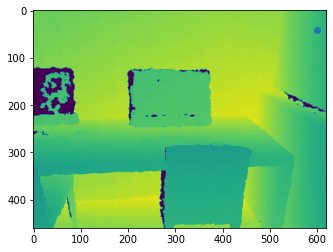

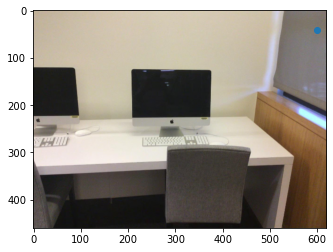

In [8]:
plt.imshow(frame_reader.get_colorAndDepth(0)[1].cpu())
plt.scatter(600,40)
plt.show()
plt.imshow(frame_reader.get_colorAndDepth(0)[0].cpu())
plt.scatter(600,40)

In [ ]:
segmenter = Segmenter(slam, cfg, args, zero_pos, 'test')

In [ ]:
segmenter.estimate_c2w_list = np.concatenate([p[None] for p in segmenter.frame_reader.poses], axis=0)

In [ ]:
import os
import shutil

folder_path = '/home/rozenberszki/project/wsnsl/test'

# Check if the folder exists
if os.path.exists(folder_path):
    # Delete the folder and its contents
    shutil.rmtree(folder_path)

# Create the folder
os.makedirs(folder_path)


In [ ]:
segmenter.runAuto()

In [ ]:
import numpy as np
import open3d as o3d
points = np.random.rand(10,3)

In [ ]:
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points)
pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30))

# Step 2: Compute a mesh using the Ball Pivoting algorithm
# You may need to adjust the radii parameter based on the scale of your point cloud
radii = [0.005, 0.01, 0.02, 0.04]
mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_ball_pivoting(
       pcd, o3d.utility.DoubleVector(radii))

# Step 3: Simplify the mesh (optional, if you need to reduce the complexity)
mesh_simplified = mesh.simplify_quadric_decimation(target_number_of_triangles=1000)
o3d.io.write_triangle_mesh("test_mesh.obj", mesh_simplified)

In [ ]:
frame_reader.n_img//50

In [ ]:
import seaborn as sns
for idx in range(0, frame_reader.n_img, 50):
    _,_, depth,_,_ = frame_reader[idx]
    sns.heatmap(depth.cpu().numpy() == 0)
    plt.show()
    plt.clf()


In [ ]:
color, depth= frame_reader.get_colorAndDepth(1000)
#_,depth = frame_reader.get_colorAndDepth(80)
color = color.cpu().numpy()
depth = depth.cpu().numpy()
depth = depth / np.max(depth)
depth = np.stack([depth, depth, depth], axis=-1)
fig, ax = plt.subplots(3, 1, figsize=(40, 13))
ax[0].imshow(depth)
#plt.show()
ax[1].imshow(color)
#plt.show()
ax[2].imshow(color*depth*5)